# Content Based - Recommendation System for movies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle

Reading files from the dataset

In [ ]:
movies=pd.read_csv(r"movies.csv")
tags=pd.read_csv(r"tags.csv")
ratings=pd.read_csv(r"ratings.csv")

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [ ]:
#remove '|' between genres
movies['genres']=movies['genres'].str.replace("|"," ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [ ]:
#number of unique movies available in movies dataset
len(movies.movieId.unique())

9125

In [ ]:
#number of unique movies rated by viewers
len(ratings.movieId.unique())

9066

In [ ]:
#limit data to the users who have at least rated 55 movies
ratings_f=ratings.groupby('userId').filter(lambda x: len(x)>=55)

#movie titles that survived after fitering

movie_list_ratings= ratings_f.movieId.unique().tolist()

In [ ]:
#proportion movies that survived after filtering

prop_movies= len(ratings_f.movieId.unique())*100/len(movies.movieId.unique())
print("Proportion :",prop_movies)

Proportion : 98.37808219178082


In [ ]:
#proportion of users survived ater filtering

prop_users= len(ratings_f.userId.unique())*100/len(ratings.userId.unique())
print("Proportion :",prop_users)

Proportion : 59.31445603576751


In [ ]:
#filter movies in movies data set
movies=movies[movies.movieId.isin(movie_list_ratings)]

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#map movies to moviID in dataset

mapping_file=dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [ ]:
#Remove timestamp from tags and ratings_f
tags.drop(['timestamp'],1,inplace=True)
ratings_f.drop(['timestamp'],1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
tags.head()

,userId,movieId,tag
0,15,339,sandra 'boring' bullock
1,15,1955,dentist
2,15,7478,Cambodia
3,15,32892,Russian
4,15,34162,forgettable


Here, we are going to use content based filtering.
The filtering will be done by using genres and tags.
So, we are going to merge movies and tags data set to get both genres and tags in one table.

In [ ]:
#mixed = movies + tags

mixed=pd.merge(movies,tags,on='movieId',how='left')
mixed.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,501.0,Pixar
1,2,Jumanji (1995),Adventure Children Fantasy,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy Romance,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy Drama Romance,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,431.0,steve martin


In [ ]:
mixed.fillna(" ",inplace=True)
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x:"%s" % ' '.join(x)))
final=pd.merge(movies,mixed,on='movieId',how="left")
final['metadata']=final[['tag','genres']].apply(lambda x:' '.join(x),axis=1)
final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Pixar Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [ ]:
final.shape

(8977, 5)

## Creating latent matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(),index=final.index.tolist())
print(tfidf_df.shape)

(8977, 698)


In [ ]:
tfidf_df.head(3)
#its like sparce matrices i.e. having more zeros than ones or actual values

,0,1,2,3,4,5,6,7,8,9,...,688,689,690,691,692,693,694,695,696,697
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimesionality reduction

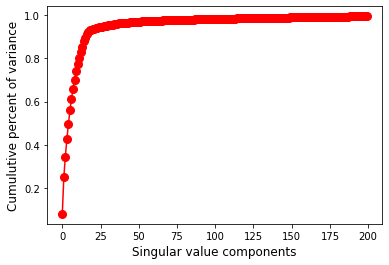

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd=TruncatedSVD(n_components=200)
latent_matrix=svd.fit_transform(tfidf_df)
explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel("Singular value components",fontsize=12)
plt.ylabel("Cumulutive percent of variance",fontsize=12)
plt.show()

#### The variance is 0.5 upto components 200.

In [ ]:
n=200
latent_matrix_1_df=pd.DataFrame(latent_matrix[:,0:n],index=final.title.tolist())

In [ ]:
latent_matrix_1_df.shape

(8977, 200)

In [ ]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.147789,0.179824,0.114567,-0.004324,0.320930,0.043501,0.002594,0.418084,-0.210718,-0.073121,...,-0.053929,-0.104333,-0.106622,0.192322,0.088137,0.103886,0.098639,-0.095759,0.006979,-0.104512
Jumanji (1995),0.084865,0.057240,0.192630,0.075567,0.502036,0.057301,0.008263,0.645755,-0.279527,-0.095068,...,0.000025,-0.000179,-0.000434,-0.000126,-0.000232,-0.000044,-0.000079,0.000200,-0.000129,0.000309
Grumpier Old Men (1995),0.543837,0.560442,-0.167092,0.585615,-0.112748,-0.037561,0.001899,-0.044141,0.022272,-0.007998,...,-0.000030,0.000055,0.000014,-0.000046,0.000004,-0.000058,0.000003,-0.000006,0.000010,-0.000074
Waiting to Exhale (1995),0.826389,0.234905,-0.241720,0.438878,-0.072173,-0.001496,-0.002195,-0.044318,0.024151,-0.001833,...,-0.000028,0.000051,-0.000011,-0.000018,0.000019,-0.000062,0.000001,-0.000011,0.000031,-0.000081
Father of the Bride Part II (1995),0.089582,0.131917,-0.006454,-0.046157,-0.008123,0.003128,-0.003631,-0.009163,0.005361,-0.007766,...,-0.002646,0.029639,0.017879,-0.023094,-0.027410,0.004861,0.033236,0.018009,-0.012705,-0.002736


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
#take latent vector for selected movie
a_1=np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1,-1)


score=cosine_similarity(latent_matrix_1_df,a_1).reshape(-1)

dictdf={'content':score}

similar=pd.DataFrame(dictdf,index=latent_matrix_1_df.index)

similar.sort_values('content',ascending=False,inplace=True)

similar[1:].head(11)

,content
Toy Story 3 (2010),0.779001
Shrek the Third (2007),0.693802
The Good Dinosaur (2015),0.693802
Turbo (2013),0.693802
"Boxtrolls, The (2014)",0.693802
"Monsters, Inc. (2001)",0.693802
"Tale of Despereaux, The (2008)",0.693802
Antz (1998),0.693802
"Adventures of Rocky and Bullwinkle, The (2000)",0.693802
"Emperor's New Groove, The (2000)",0.680385
